In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import pandas as pd
import datetime as dt
import seaborn as sns
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing

In [3]:
data=pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv")

In [4]:
data

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [5]:
data.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
data.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [8]:
#We have 24 data points for each day
#I will try to predict hourly power consumptionfor any day provided we have data for n(3,5,7,10 or any value which gives better results) days prior to it


In [9]:
#rescaling our data
scaler = sklearn.preprocessing.MinMaxScaler()

data["normalised_data"]=scaler.fit_transform(data['AEP_MW'].values.reshape(-1,1))

In [10]:
data

,Datetime,AEP_MW,normalised_data
0,2004-12-31 01:00:00,13478.0,0.241839
1,2004-12-31 02:00:00,12865.0,0.203798
2,2004-12-31 03:00:00,12577.0,0.185925
3,2004-12-31 04:00:00,12517.0,0.182202
4,2004-12-31 05:00:00,12670.0,0.191697
...,...,...,...
121268,2018-01-01 20:00:00,21089.0,0.714162
121269,2018-01-01 21:00:00,20999.0,0.708576
121270,2018-01-01 22:00:00,20820.0,0.697468
121271,2018-01-01 23:00:00,20415.0,0.672335


In [11]:
n=7 #Number of prior days you want to pass to the LSTM model
m=1 #Number of days for which you want to predict
Train=data["normalised_data"][:-(24*n+24*m)]
Test=data["normalised_data"].tail(24*n+24*m)
Test = Test.reset_index(drop=True) # resetting indices for test because we used .tail(), which keeps old indices in place

In [12]:
Train

0         0.241839
1         0.203798
2         0.185925
3         0.182202
4         0.191697
            ...   
121076    0.490815
121077    0.489512
121078    0.467358
121079    0.428261
121080    0.388296
Name: normalised_data, Length: 121081, dtype: float64

In [13]:
Test.shape

(192,)

In [14]:
#Preprocessing our dataset before feeding into LSTM

X_Train = []
Y_Train = []

for i in range(24*n, Train.shape[0]):
    
    X_Train.append(Train[i-24*n:i])
    
    
    Y_Train.append(Train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(120913, 168)
(120913,)


In [15]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(120913, 168, 1)

In [16]:
X_Test = []
Y_Test = []


for i in range(24*n, Test.shape[0]):
    
    
    X_Test.append(Test[i-24*n:i])
    
    
    Y_Test.append(Test[i])

# Convert into Numpy Array
X_Test = np.array(X_Test)
Y_Test = np.array(Y_Test)

print(X_Test.shape)
print(Y_Test.shape)


(24, 168)
(24,)


In [17]:
X_Test = np.reshape(X_Test, newshape=(X_Test.shape[0], X_Test.shape[1], 1))
X_Test.shape

(24, 168, 1)

In [18]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 512, return_sequences = True, input_shape = (X_Train.shape[1], 1),))
#regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 256, return_sequences = True,))
#regressor.add(Dropout(0.1))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 128, return_sequences = True,))
#regressor.add(Dropout(0.05))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64))
#regressor.add(Dropout(0.2))
regressor.add(Dense(256, activation='relu'))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [19]:
regressor.fit(X_Train, Y_Train, epochs = 10, batch_size = 256)

Epoch 1/10
473/473 [==============================] - 75s 144ms/step - loss: 0.0149
Epoch 2/10
473/473 [==============================] - 68s 144ms/step - loss: 0.0023
Epoch 3/10
473/473 [==============================] - 68s 144ms/step - loss: 9.2416e-04
Epoch 4/10
473/473 [==============================] - 68s 143ms/step - loss: 5.1363e-04
Epoch 5/10
473/473 [==============================] - 68s 143ms/step - loss: 4.5979e-04
Epoch 6/10
473/473 [==============================] - 68s 143ms/step - loss: 4.0466e-04
Epoch 7/10
473/473 [==============================] - 68s 143ms/step - loss: 4.0013e-04
Epoch 8/10
473/473 [==============================] - 68s 144ms/step - loss: 3.6021e-04
Epoch 9/10
473/473 [==============================] - 68s 144ms/step - loss: 3.5340e-04
Epoch 10/10
473/473 [==============================] - 68s 143ms/step - loss: 3.7067e-04


In [20]:
pred=regressor.predict(X_Test)

In [21]:
Y_Test

array([0.55399032, 0.55969964, 0.55789996, 0.56503661, 0.57906169,
       0.59780315, 0.62082661, 0.63950602, 0.64242274, 0.63708576,
       0.62858384, 0.61263498, 0.58756361, 0.56820156, 0.56087874,
       0.5653469 , 0.59128708, 0.66389475, 0.70398411, 0.7141616 ,
       0.70857639, 0.69746804, 0.67233462, 0.64614621])

In [22]:
scaler.fit(data["AEP_MW"].values.reshape(-1,1))

MinMaxScaler()

In [23]:
rescaled=scaler.inverse_transform(pred)

In [24]:
rescaled

array([[18230.16 ],
       [17977.959],
       [18543.744],
       [18694.545],
       [19023.941],
       [19524.697],
       [19945.377],
       [20089.37 ],
       [19960.486],
       [19816.82 ],
       [19572.572],
       [19263.297],
       [19031.219],
       [18541.488],
       [18400.127],
       [18547.795],
       [19003.27 ],
       [19866.19 ],
       [20989.48 ],
       [20875.342],
       [20971.275],
       [20742.975],
       [20301.123],
       [19620.346]], dtype=float32)

In [25]:
rescaled_test=scaler.inverse_transform(Y_Test.reshape(-1,1))

In [26]:
rescaled_test

array([[18508.],
       [18600.],
       [18571.],
       [18686.],
       [18912.],
       [19214.],
       [19585.],
       [19886.],
       [19933.],
       [19847.],
       [19710.],
       [19453.],
       [19049.],
       [18737.],
       [18619.],
       [18691.],
       [19109.],
       [20279.],
       [20925.],
       [21089.],
       [20999.],
       [20820.],
       [20415.],
       [19993.]])

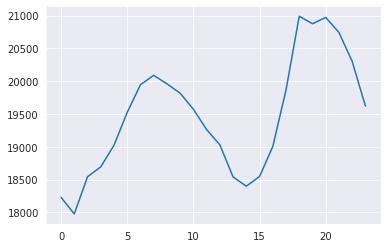

In [27]:
#plotpred


sns.set_style("darkgrid")

plt.plot(np.arange(0,24),rescaled)
plt.show()

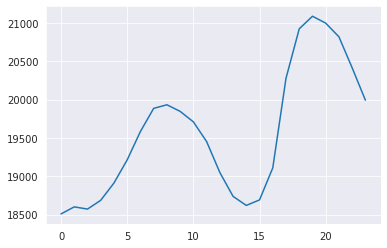

In [28]:
#plotactual
sns.set_style("darkgrid")

plt.plot(np.arange(0,24),rescaled_test)
plt.show()


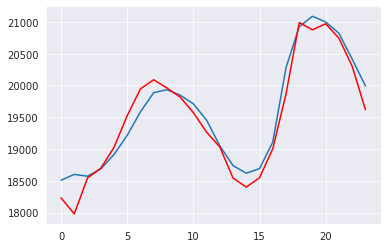

In [29]:
sns.set_style("darkgrid")

#original-blue
plt.plot(np.arange(0,24),rescaled_test)
#predicted-red
plt.plot(np.arange(0,24),rescaled,color="red")


plt.show()